In [1]:
import mne
mne.set_log_level('error')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

# Charging the data

Each subjects perform 14 experimental runs:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4


In [2]:
# Create a list with each tipe of experimental run
runs_openeye = [1]
runs_clodeseye = [2]
runs_fists = [3, 7, 11]
runs_imagine_fists = [4, 8, 12]
runs_fistsfeet = [5, 9, 13]
runs_imagine_fistsfeet = [6, 10, 14]

# List with the ID of each participant
participants = [_ for _ in range(1,110)]


# Defining the EEG standard EEG bands. These are indicative situation in which we see appearing this type of waves on healty subjects.
delta_waves = {
    'freq_min': 0.5,
    'f_max': 4
} # normally occur during deep sleep

theta_waves = {
    'freq_min': 4,
    'freq_max': 8
} # transiently during sleep

alpha_waves = {
    'freq_min': 8, 
    'freq_max': 12
} # relaxed but awake state, resting with the eyes closed

beta_waves = {
    'freq_min': 12, 
    'freq_max': 30   
} # attention to tasks or stimuli,logical thinking

gamma_waves = {
    'freq_min': 30, 
    'freq_max': 70  
} # large-scale brain network activity and cognitive phenomena such as working memory, attention



Motor activity often produce alpah and beta waves

In [3]:
# Charging the data
participant = 14
run = 3
file_path = f'files/S{participant:03}/S{participant:03}R{run:02}.edf'

# Preload = True charges also the data, not just the headers
raw = read_raw_edf(file_path, preload = True)

# Setting the montage

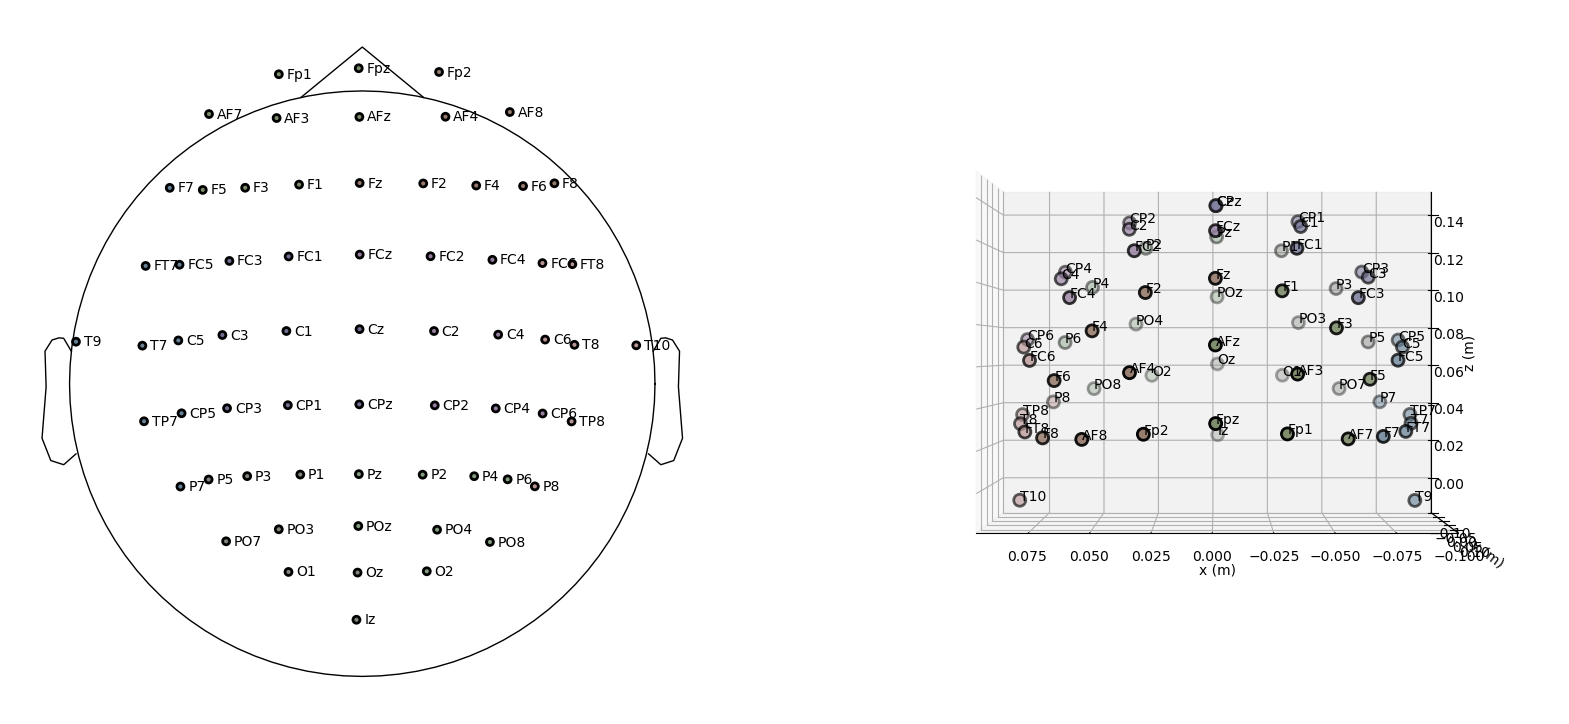

In [4]:
# We choose the "Standard_1020" montage
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# Here we change the names of the electrode to match the standard notation and set the choosen montage on the raw data charged.

# Dictionary with the structure old_name : correct_cases_name. To respect the upper and lower cases of the standard notation for the electrde's position.
replacement = {
    'Fc': 'FC',
    'Cp': 'CP',
    'Af': 'AF',
    'Ft': 'FT',
    'Tp': 'TP',
    'Po': 'PO'   
}

# new_name is the dictionary to use to cange the name of the electrode's positions to respect the usual sandard notataions.
# First get rid of the excessive "." 
new_names = {
    name : name.replace(".", "") for name in raw.info['ch_names']
}   

# Change the lower and upper case of the electrode's names
for key in new_names.keys():
    for old_string, new_string in replacement.items():
        new_names[key] = new_names[key].replace(old_string, new_string)

# Choose the montage and set it for the uploaded data
# montage = 'standard_1020'
raw.rename_channels(new_names)
raw.set_montage(montage)


# Plot the 2D projection and the 3D representation of the choosen montage
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Plot the 2D montage
ax1 = fig.add_subplot(gs[0])
raw.info.plot_sensors(ch_type = 'eeg', show_names=True, ch_groups='position', axes=ax1, show=False)

# Plot the 3D montage
ax2 = fig.add_subplot(gs[1], projection='3d')
raw.info.plot_sensors(kind = "3d", ch_type = 'eeg', show_names=True, ch_groups='position', axes=ax2, show=False)

plt.show()


# Apply filter

/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


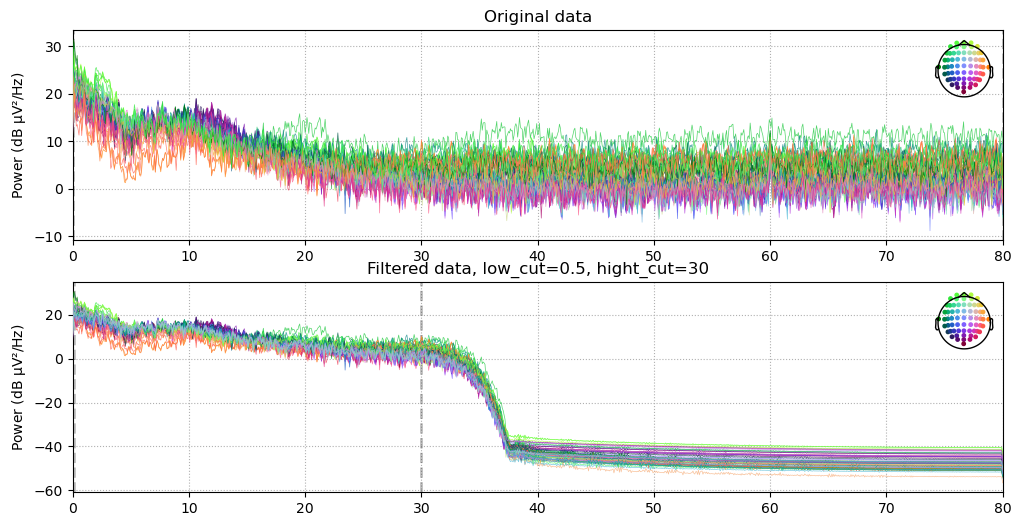

In [5]:
# Filter setting
low_cut = 0.1 # We filter the low frequency to remove slow drift
high_cut = 30 # We filter the high frequency to eliminate noise, and because the motor signals appears mostly as alpha and beta waves

# copy the raw data and apply the filter
raw_filt = raw.load_data().copy().filter(low_cut, high_cut)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6)) 

raw.compute_psd().plot(axes = ax1)
ax1.set_title("Original data")

raw_filt.compute_psd().plot(axes = ax2)
ax2.set_title("Filtered data, low_cut=0.5, hight_cut=30")

plt.show()

In [6]:
# raw.plot(title='original')
# raw_filt.plot(title='filtered')

# ICA

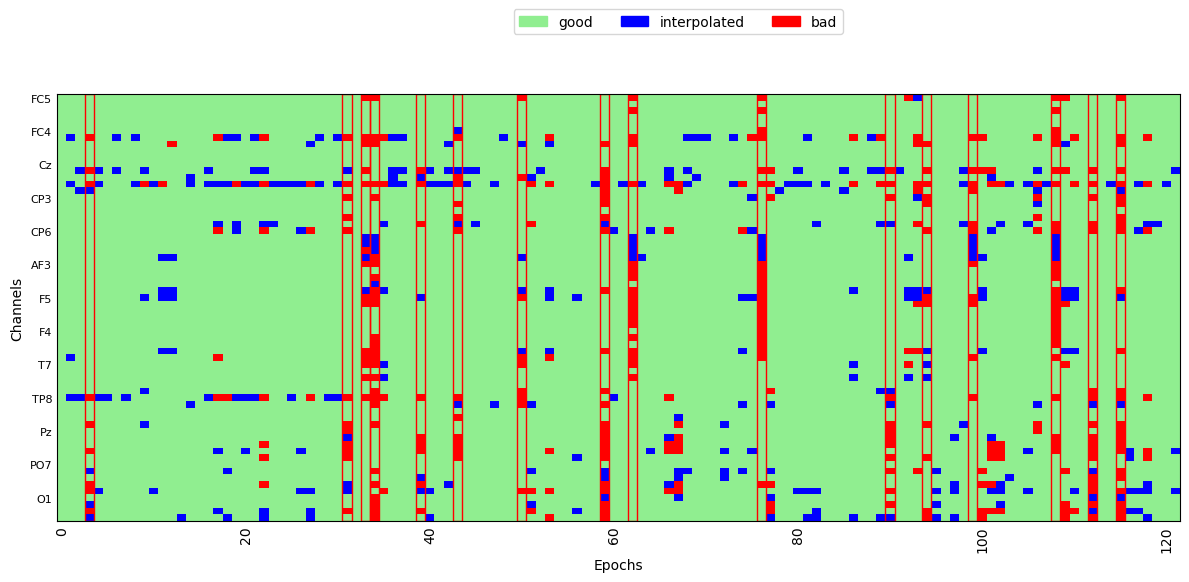

In [7]:
from autoreject import AutoReject


# Filter settings for ICA
ica_low_cut = 1
high_cut = 30

# Creating a raw data to use to compute the ICA
raw_ica = raw.copy().filter(ica_low_cut, high_cut)

# Creating the epochs for the artifact detection and the ICA
time_step = 1 # Coerent with the time-span of the most common artifact (heart, eye blink)
events_ica = mne.make_fixed_length_events(raw_ica, duration=time_step)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=time_step,
                        baseline=None,
                        preload=True)

# We use the autoreject function to clean clean the data before applying ICA, indeed it automatically 
# determine a threshold to use to find sections of the data that are excessively noisy. 
# This can occur, for example, if a participant scratches their head during a recording, or sneezes, or for various other reasons.

# Instancing the autoreject object
ar = AutoReject(
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)
reject_log.plot('horizontal', aspect='auto');

/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


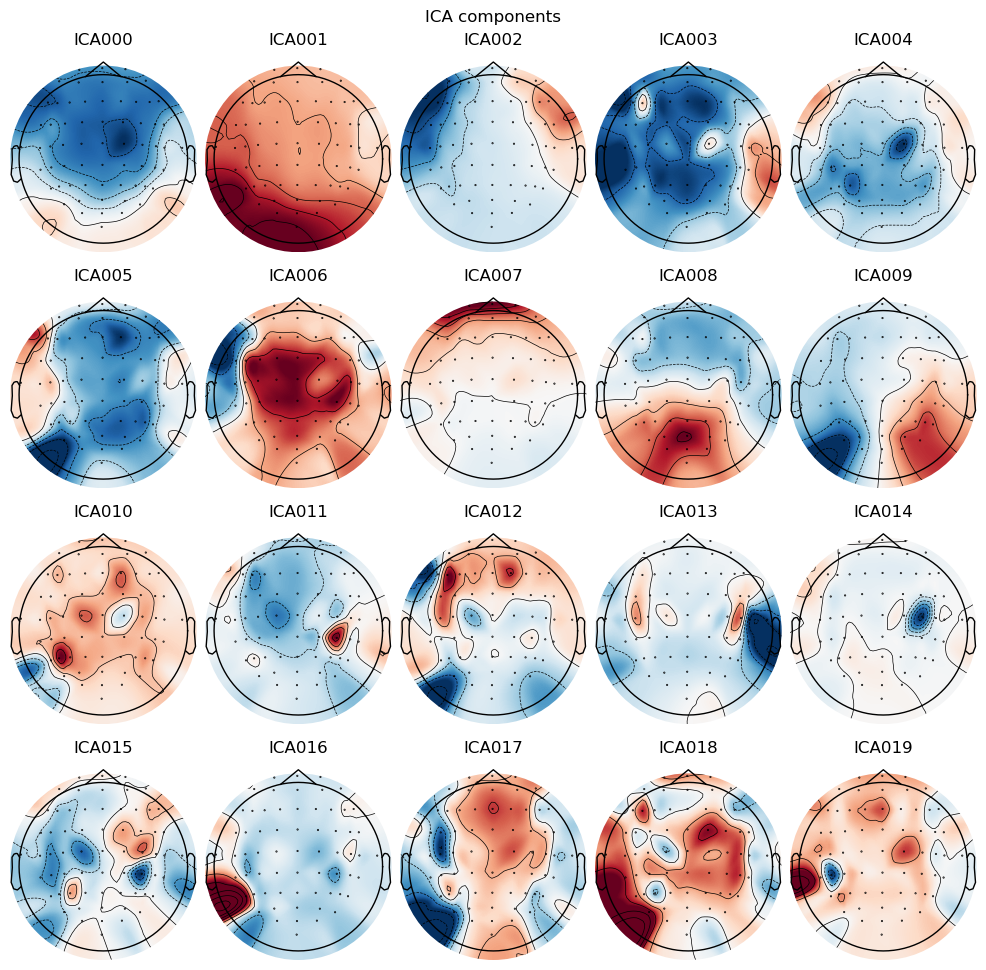

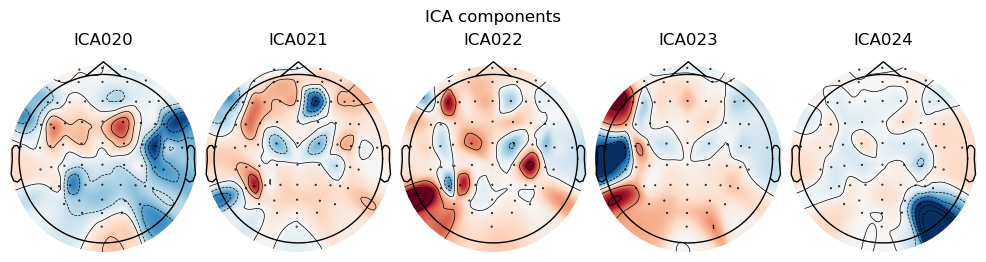

In [8]:
# ICA parameters
random_state = 0   # ensures ICA is reproducible each time it's run
ica_n_components = 25    # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

# ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': high_cut});
ica.plot_components();

Final z threshold = 3.0
The IC indices are:  [7, 2]


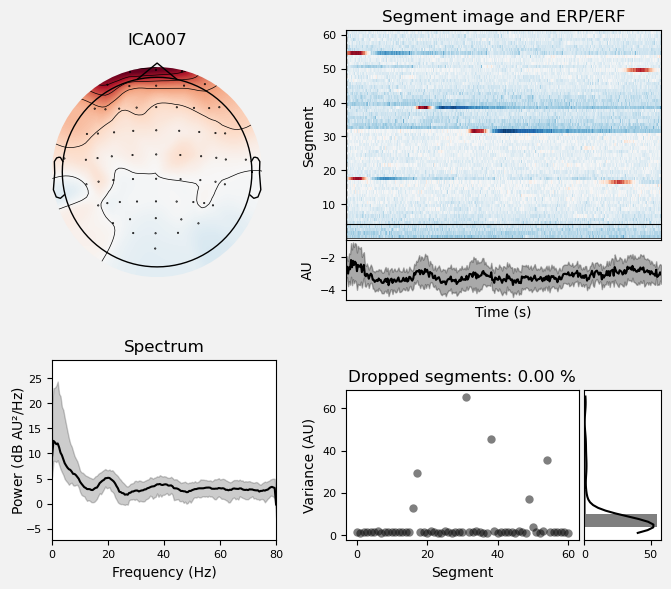

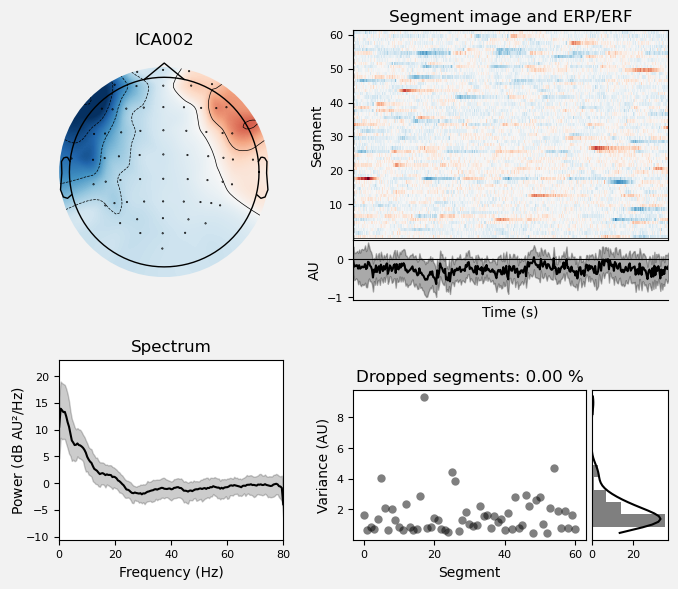

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [9]:
ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=['Fp1', 'Fp2', 'F7', 'F8'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 


# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))
print('The IC indices are: ', eog_indices)
# ica.plot_scores(eog_scores); # Plot the socre for each channel choosed
ica.plot_properties(raw, picks=eog_indices)

In [97]:
ica.plot_sources(epochs_ica)

In [1]:
ica.exclude = []
# find which ICs match the ECG pattern
num_excl = 0
max_ic = 1
z_thresh = 3.5
z_step = .05

while num_excl < max_ic: 
    ecg_indices, ecg_scores = ica.find_bads_ecg(epochs_ica, 
                                                ch_name='T9', 
                                                threshold=z_thresh)
    
    num_excl = len(ecg_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# # barplot of ICA component "ECG match" scores
ica.exclude = ecg_indices
ica.plot_scores(ecg_scores);

# # plot diagnostics
# ica.plot_properties(epochs_ica)

# # # plot ICs applied to raw data, with ECG matches highlighted
# ica.plot_sources(epochs_ica)

# # plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
# ica.plot_sources(ecg_evoked)

NameError: name 'ica' is not defined

In [2]:
ecg_indices

NameError: name 'ecg_indices' is not defined

In [84]:
ica.plot_sources(epochs_ica)

In [44]:
# ica.plot_scores(eog_scores); # Plot the socre for each channel choosed

ica.plot_sources(raw, show_scrollbars=False)

In [33]:
ica.plot_sources(epochs_ica, show_scrollbars=False)

In [22]:
epochs_ica.plot()

# ERP

The event_dict is:  {'T0': 1, 'T1': 2, 'T2': 3}


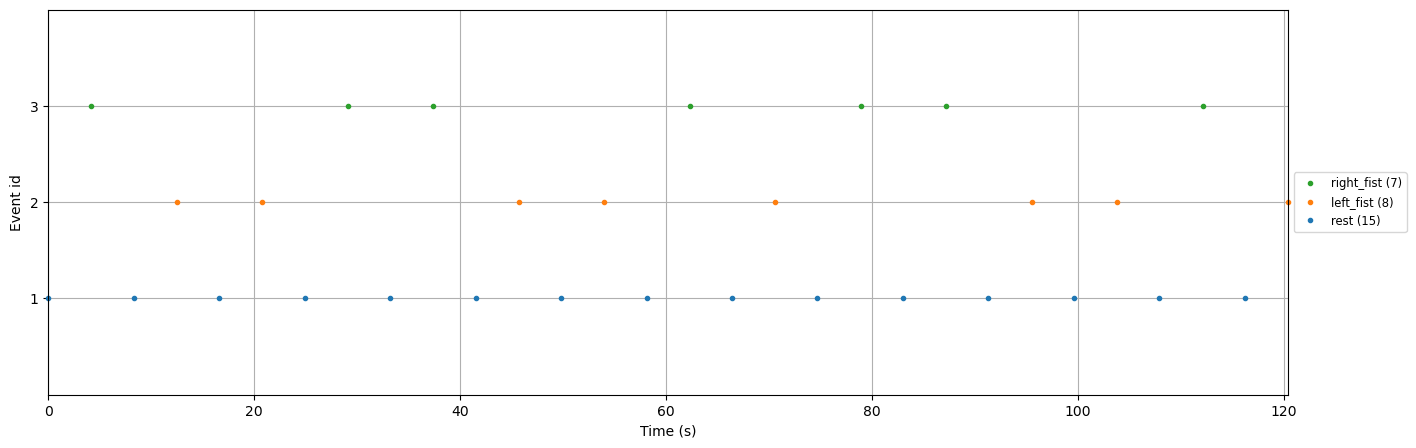

In [46]:
events, events_dict = mne.events_from_annotations(raw_filt)

print('The event_dict is: ', events_dict)

event_mapping = {
    1: 'rest',
    2: 'left_fist',
    3: 'right_fist'
}

event_id = {v:k for k,v in event_mapping.items()}

fig, ax = plt.subplots(figsize=[20, 5])

mne.viz.plot_events(events, raw_filt.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()

## Creating the epochs

In [ ]:
epoch_duration = 656. / raw_filt.info['sfreq']
epoch_duration

# Question, should I use another time-interval ? Should I start the epoch during the resting ?
# Epoching settings
tmin =  0.  # start of each epoch (in sec)
tmax =  4.1  # end of each epoch (in sec)
baseline = (0, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 